In [23]:
import requests
import shutil
import os
import time
import math
import json
from tqdm import tqdm
from glob import glob

# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
np.__version__
import matplotlib.pyplot as plt
import cv2

import pandas as pd


In [2]:
timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/data.csv"
DATASET_PATH = org_img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/"	# "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/"
craft_res_dir = org_img_dir.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = org_img_dir.replace('/scraped-data/', '/seg-results/')


Note: There are 7,982,741 images avaialble in GBIF database, but we only scrapped 1198 images for evaluation purpose. If you want to see the amount of data that we have, use the following code, or you can checkout the 'scraping' folder to scrape more data from the website.

```python
# If you want to read the data from that data.csv file
import pandas as pd
df = pd.read_csv(DATASET_PATH + DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")
```



## Extract the bounding box that detected by CRAFT

In [3]:
boxes = {}
def addBox(fname):
	if ".jpg" in fname and "mask" not in fname:
		# imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))
		tmp_txt = open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n")[:-1]
		tmp_txt = [line.split(",") for line in tmp_txt]
		tmp_bxs = [[[int(line[i]),int(line[i+1])] for i,val in enumerate(line) if int(i)%2==0] for line in tmp_txt ]
		boxes[fname[4:len(fname)-4]] = tmp_bxs
		return boxes
def fillBoxes():
	print("\nFilling boxes dictionary...")
	print("Starting multiprocessing...")
	list_imgs = sorted(os.listdir(craft_res_dir))
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addBox, list_imgs), total=len(sorted(os.listdir(craft_res_dir)))):
		if item: boxes.update(item)
	pool.close()
	pool.join()
	print("\nBoxes dictionary filled.\n")
# Get all the bounding boxes that segmented by CRAFT
fillBoxes()
print(f"imgIDs that extracted by CRAFT: {boxes.keys()}")


Filling boxes dictionary...
Starting multiprocessing...


100%|██████████| 90/90 [00:00<00:00, 8855.59it/s]


Boxes dictionary filled.

imgIDs that extracted by CRAFT: dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


## Let's get all the image ids and store them in a dictionary, with imgID as key, and a img numpy arr as value

In [4]:
img_dict = {}	# Dict<int: imgId, nparr: img>

def addImg(fIdx):
	# By default, cv2.imread() use BGR, if you want to read in grayscale use, cv2.imread('image_1.png', 1)
	temp_img = cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))	
	# convert image form BGR to RGB color for matplotlib
	img_dict[fIdx] = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
	return img_dict

def getOrigImgs():
	print("Getting original images...")
	print("Starting multiprocessing...")
	file_list = sorted(os.listdir(DATASET_PATH))
	imgIds_list = [img[:-4] for img in file_list if ".jpg" in img]
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addImg, imgIds_list), total=len(imgIds_list)):
		img_dict.update(item)
	pool.close()
	pool.join()
	print("\nOriginal images obtained.\n")
getOrigImgs()
img_list = list(img_dict.items())	# a list of Tuple<int: imgId, nparr: img>

Getting original images...
Starting multiprocessing...


100%|██████████| 30/30 [00:03<00:00,  9.70it/s]


Original images obtained.



## Let's visualize some sampled images

In [6]:
# visualize craft outputs

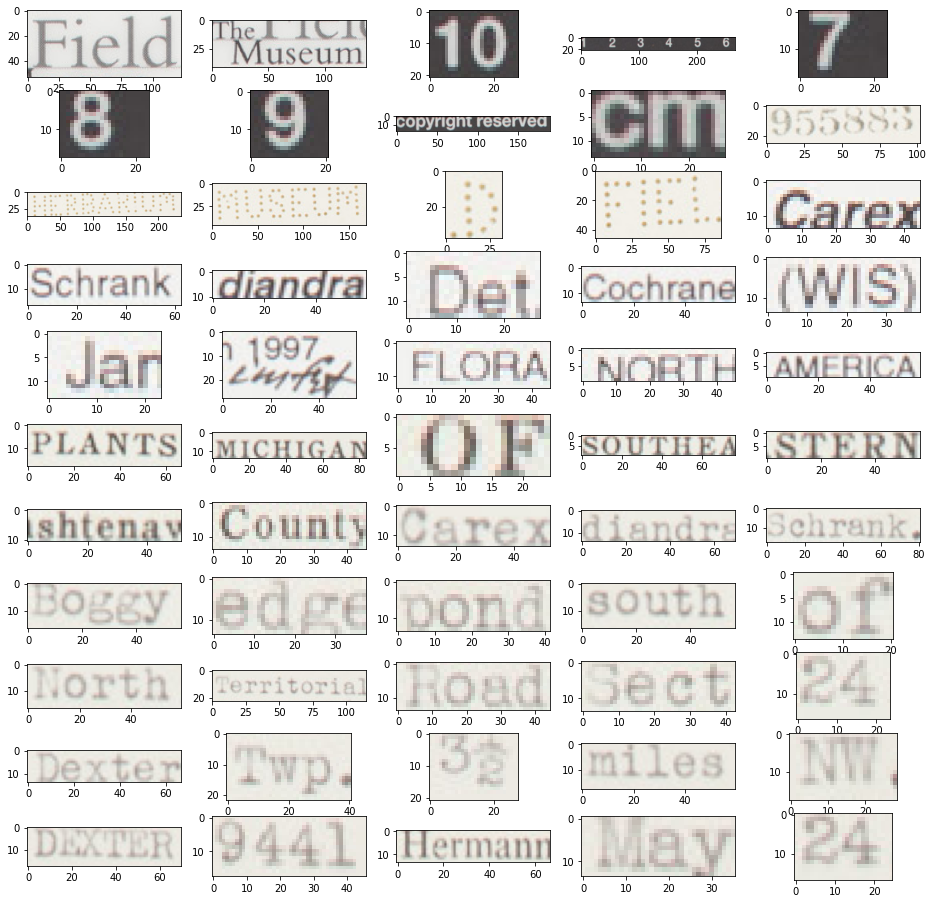

In [20]:
def img_crop(image_num, box_num):
    y = boxes[img_list[0][0]][box_num][0][0]
    x = boxes[img_list[0][0]][box_num][0][1]
    dy = boxes[img_list[0][0]][box_num][2][0] - boxes[img_list[0][0]][box_num][0][0]
    dx = boxes[img_list[0][0]][box_num][2][1] - boxes[img_list[0][0]][box_num][0][1]
    if (x > img_list[image_num][1].shape[0] or y > img_list[image_num][1].shape[1]): return None
    x_crop = img_list[image_num][1][x:x+dx,:,:]
    y_crop = x_crop[:,y:y+dy,:]
    return y_crop

fig = plt.gcf()
fig.set_size_inches(2*8, 2*8)
for x in range(len(boxes[img_list[0][0]]) - 1): 
    img = img_crop(0, x)
    plt.subplot(len(boxes[img_list[0][0]])//5, 5, x+1)
    plt.imshow(img)


gray_img: (2250, 1500)


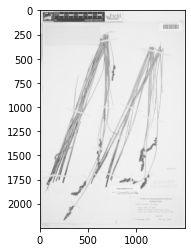

In [21]:
# convert image to grayscale
gray_img = cv2.cvtColor(img_list[0][1], cv2.COLOR_RGB2GRAY)
print(f"gray_img: {gray_img.shape}") # grayscale image represented as a 2-d array

# have to convert grayscale back to RGB for plt.imshow()
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB))

In [77]:
df = pd.DataFrame(sum(boxes.values(),[]))
df["width"] = df[2].apply((lambda row:row[0]))- df[0].apply((lambda row:row[0]))
df["hight"] = df[2].apply((lambda row:row[1]))- df[0].apply((lambda row:row[1]))
df = df.drop([0,1,2,3], axis=1)
df["area"] = df["width"]*df["hight"]
df.head()

,width,hight,area
0,123,53,6519
1,137,42,5754
2,28,21,588
3,267,21,5607
4,24,18,432


<AxesSubplot:ylabel='Frequency'>

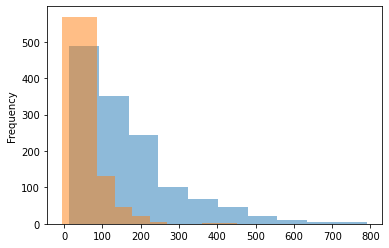

In [86]:
df["width"].plot.hist(alpha=0.5)
df["hight"].plot.hist(alpha=0.5)


<AxesSubplot:>

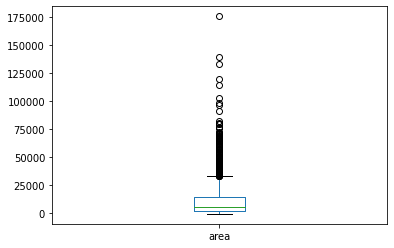

In [92]:
df["area"].plot.box()